# Fundamentals-of-Neural-Networks
This project is part of the 5LSH0 - Computer Vision AI and 3D Data Analysis course at TU Eindhoven. It focuses on the fundamentals of neural networks, with an emphasis on implementing a Multi-Layer Perceptron (MLP) to classify digits from the MNIST dataset. You will work with fully-connected layers, activation functions (ReLU and Sigmoid), and mini-batch SGD with cross-entropy loss. The project also involves analyzing the model’s performance, calculating trainable parameters, and experimenting with different loss functions such as Cross-Entropy, Dice, and Focal Loss to enhance accuracy.

### Variables explanation
- **W1**: Weights for the first layer (input to hidden layer)
- **b1**: Bias for the first layer
- **W2**: Weights for the second layer (hidden to output layer)
- **b2**: Bias for the second layer
- **A1**: Activation of the first layer (output after applying activation function to Z1)
- **A2**: Output of the network (after applying softmax activation function to Z2)
- **Z1**: Linear transformation for the first layer (W1.dot(values) + b1)
- **Z2**: Linear transformation for the second layer (W2.dot(A1) + b2)
- **m**: Number of training examples (samples in the training set)
- **n**: Number of features (including labels)
- **values**: Input features (e.g., pixel values for MNIST images)
- **labels**: Ground truth labels (e.g., corresponding digit labels for MNIST images)
- **dW1**: Gradient of the weights for the first layer
- **db1**: Gradient of the bias for the first layer
- **dW2**: Gradient of the weights for the second layer
- **db2**: Gradient of the bias for the second layer
- **alpha**: Learning rate (step size for weight updates)

MBGD(early implementation), iterations: 500, alpha: 0.1, activation: sigmoid, batch size: 64\
training time: 10min, test accuracy: 0.65, test loss: 1.04\
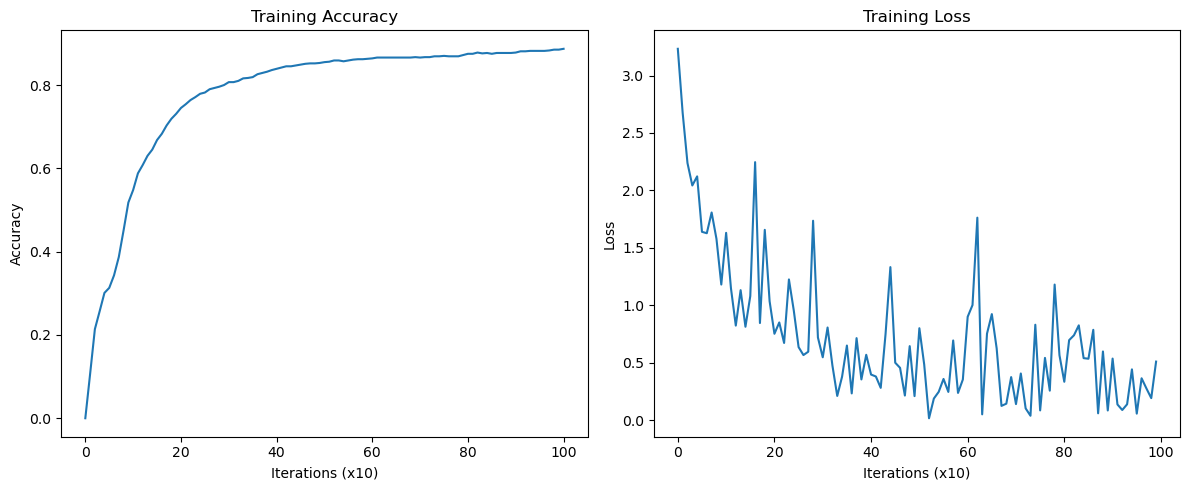

MBGD, iterations: 2000, alpha: 0.1, activation: sigmoid, batch size: 64\
training time: 5682s, test accuracy: 0.931, test loss: 0.290\
comment: bad label on loss graph, loss ploted only from single batch (leading to a lot of noise)\
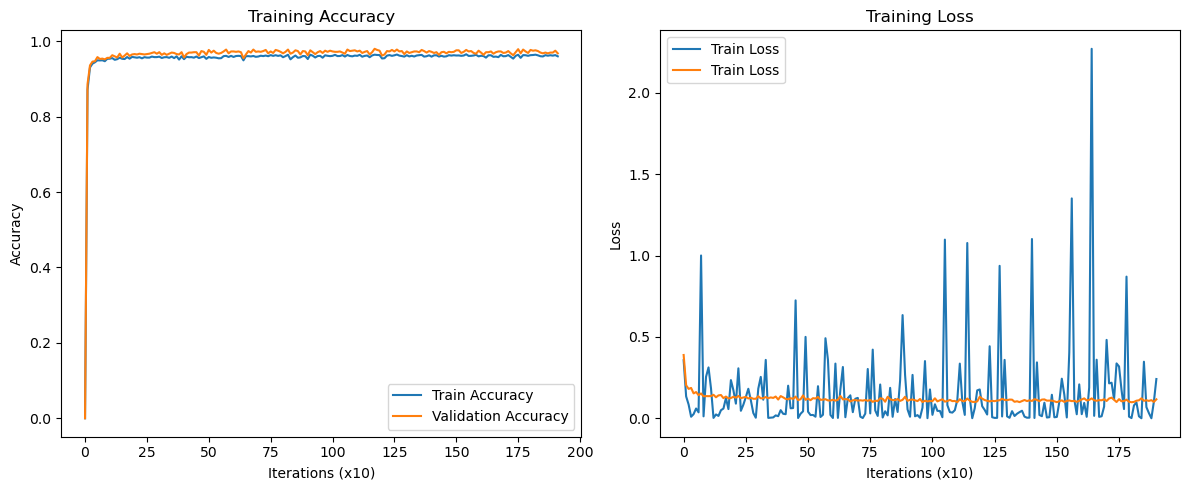

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
ALPHA = 0.1
EPOCHS = 2000
BATCHSIZE = 64
TRAININIG_UPDATES = 10 # number of iterations after which trainiing update is printed
TRAINING_SHOW_UPDATES = 100 # number of iterations after which trainiing plot is shown

In [3]:
def show_image(values, index):
    """
    Display image selected by index from given values matrix
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

In [4]:
#Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
if DEBUG:
    print(data.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


n = 785
m = 70000
labels_train.shape = (69000,)
values_train.shape = (784, 69000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


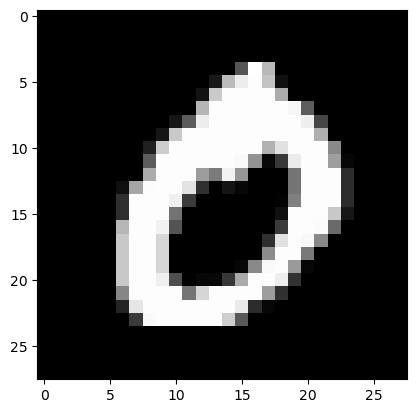

In [5]:
# Divide dataset to test, validation and train sets

data = np.array(data)
m, n = data.shape # n is amount of features including labels 

np.random.shuffle(data)

data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n] / 255

data_validation = data[TEST_SIZE:(TEST_SIZE+ VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n] / 255

data_train = data[TEST_SIZE:m].T
labels_train = data_train[0]
values_train = data_train[1:n] / 255

if DEBUG:
    print("n =",n)
    print("m =",m)
    print("labels_train.shape =",labels_train.shape)
    print("values_train.shape =",values_train.shape)
    print("labels_test.shape =",labels_test.shape)
    print("values_test.shape =",values_test.shape)
    show_image(values_train, 1)

In [6]:
def init_params():
    """Initialize NN weights and biases"""
    #
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    """Calculate ReLu activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Calculate Sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    """Calculate softmax of given vector Z"""
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_propagation(W1, b1, W2, b2, values):
    """Pass through the NN input->output"""
    Z1 = W1.dot(values) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(labels, num_classes=10):
    """Perform one-hot encoding for a batch of labels"""
    one_hot_labels = np.zeros((num_classes, labels.size))
    one_hot_labels[labels, np.arange(labels.size)] = 1
    return one_hot_labels

def deriv_ReLU(Z):
    """Derivative of ReLU activation function"""
    return Z > 0

def deriv_sigmoid(Z):
    """Calculate derivative of sigmoid activation function"""
    return sigmoid(Z) * (1 - sigmoid(Z))
    
def back_propagation(Z1, A1, Z2, A2, W2, values, labels):
    """Perform back propagation through NN output->input"""

    # Calculate output error compared to one hot labels
    one_hot_labels = one_hot(labels)
    dZ2 = A2 - one_hot_labels

    # Calculate gradients for weights in second layer
    dW2 = 1 / BATCHSIZE * dZ2.dot(A1.T)
    db2 = 1 / BATCHSIZE * np.sum(dZ2, 1)

    # calculate first layers error by propagating error backwards
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)

    # Calculate gradients for weights in first layer
    dW1 = 1 / BATCHSIZE * dZ1.dot(values.T)
    db1 = 1 / BATCHSIZE * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update NN weights and biases"""
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10,1)) # reshape from single value to vector
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10,1)) # reshape from single value to vector
    return W1, b1, W2, b2

In [7]:
def cross_entropy_loss(A2, one_hot_labels):
    """
    Calculate cross-entropy loss
    A2: predicted probabilities from softmax (shape: [num_classes, batch_size])
    one_hot_labels: one-hot encoded true labels (shape: [num_classes, batch_size])
    """

    log_probs = np.log(A2)

    # Calculate the loss for each example: sum of true labels * log(probabilities)
    loss_sample = -np.sum(one_hot_labels * log_probs, axis=0)

    loss = np.mean(loss_sample)
    
    return loss

In [8]:
def get_predictions(A2):
    """Use highest value from given vector for prediction"""
    return np.argmax(A2, 0)

def get_accuracy(predictions, labels):
    """Calculate accuracy based on given predictions and labels"""
    return np.sum(predictions == labels) / labels.size

def make_predictions(values, W1, b1, W2, b2):
    """Make prediction based on chosen values using given model parameters"""
    _, _, _, A2 = forward_propagation(W1,b1,W2,b2,values)
    predictions = get_predictions(A2)
    return predictions
    
def mini_batch_gradient_descent(values_train, labels_train, epochs, alpha, batch_size, values_validation, labels_validation):
    """Create a 3-layer NN and train it using mini-batch gradient descent"""
    start_time = time.time()
    W1, b1, W2, b2 = init_params()
    accuracy_validation_history = [0]
    accuracy_train_history = [0]
    loss_validation_history = []
    loss_train_history = []

    # Number of training examples
    m = values_train.shape[1]

    cumulative_loss_train = 0

    for i in range(epochs):
        # Shuffle training data for each iteratnion
        permutation = np.random.permutation(m)
        values_train_shuffled = values_train[:, permutation]
        labels_train_shuffled = labels_train[permutation]

        # Mini-batch gradient descent
        for j in range(0, m, batch_size): #potential problem with last batch?

            # Divide into mini-batches
            batch_values = values_train_shuffled[:, j:j+batch_size]
            batch_labels = labels_train_shuffled[j:j+batch_size]

            # Forward propagation
            Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, batch_values)

            # Back propagation
            dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W2, batch_values, batch_labels)

            # Update parameters after each mini-batch
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

            # Sum loss across all mini-batches
            loss_minibatch_train = cross_entropy_loss(A2, one_hot(batch_labels))
            cumulative_loss_train += loss_minibatch_train


        # Training progress
        if i % TRAININIG_UPDATES == 0:
            print(f"Epoch {i} out of {epochs}")

            # Make predictions and test accuracy using validation set
            predictions_train = make_predictions(values_train, W1, b1, W2, b2)
            accuracy_train = get_accuracy(predictions_train, labels_train)

            # Calculate average loss across batches
            loss_train = cumulative_loss_train / (m / batch_size)

            # Make predictions and test accuracy using validation set
            _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values_validation)
            predictions_validation = make_predictions(values_validation, W1, b1, W2, b2)
            accuracy_validation = get_accuracy(predictions_validation, labels_validation)
            loss_validation = cross_entropy_loss(A2, one_hot(labels_validation))

            # Store training progress
            accuracy_train_history.append(accuracy_train)
            accuracy_validation_history.append(accuracy_validation)
            loss_train_history.append(loss_train)
            loss_validation_history.append(loss_validation)

            if i % TRAINING_SHOW_UPDATES == 0:
                # present traininig progress
                print(f"Train Accuracy: {accuracy_train:.3f}")
                print(f"Validation Accuracy: {accuracy_validation:.3f}")
                print(f"Train Loss: {loss_train:.3f}")
                print(f"Validation Loss: {loss_validation:.3f}")
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

                ax[0].plot(accuracy_train_history, label="Train Accuracy")
                ax[0].plot(accuracy_validation_history, label="Validation Accuracy")
                ax[0].set_title("Training Accuracy")
                ax[0].set_xlabel(f"Iterations (x{TRAININIG_UPDATES})")
                ax[0].set_ylabel("Accuracy")
                ax[0].legend()

                ax[1].plot(loss_train_history, label="Train Loss")
                ax[1].plot(loss_validation_history, label="Train Loss")
                ax[1].set_title("Training Loss")
                ax[1].set_xlabel(f"Iterations (x{TRAININIG_UPDATES})")
                ax[1].set_ylabel("Loss")
                ax[1].legend()

                plt.tight_layout()
                plt.show()

    end_time = time.time()  # End the timer
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")            

    return W1, b1, W2, b2


Iteration 0 out of 2000
Train Accuracy: 0.871
Validation Accuracy: 0.886
Train Loss: 0.357
Validation Loss: 0.389


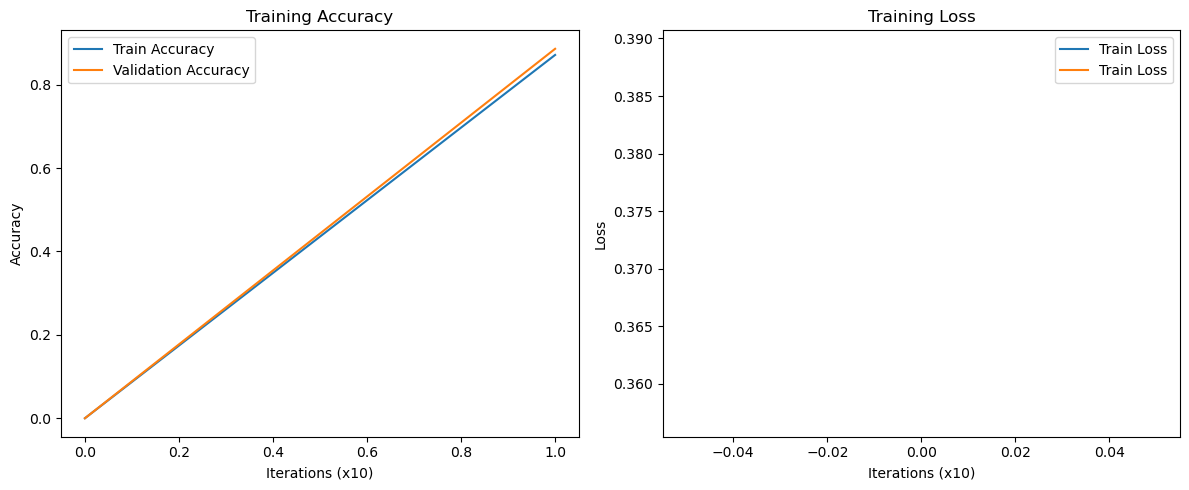

Iteration 10 out of 2000
Iteration 20 out of 2000
Iteration 30 out of 2000
Iteration 40 out of 2000
Iteration 50 out of 2000
Iteration 60 out of 2000
Iteration 70 out of 2000
Iteration 80 out of 2000
Iteration 90 out of 2000
Iteration 100 out of 2000
Train Accuracy: 0.955
Validation Accuracy: 0.963
Train Loss: 0.313
Validation Loss: 0.136


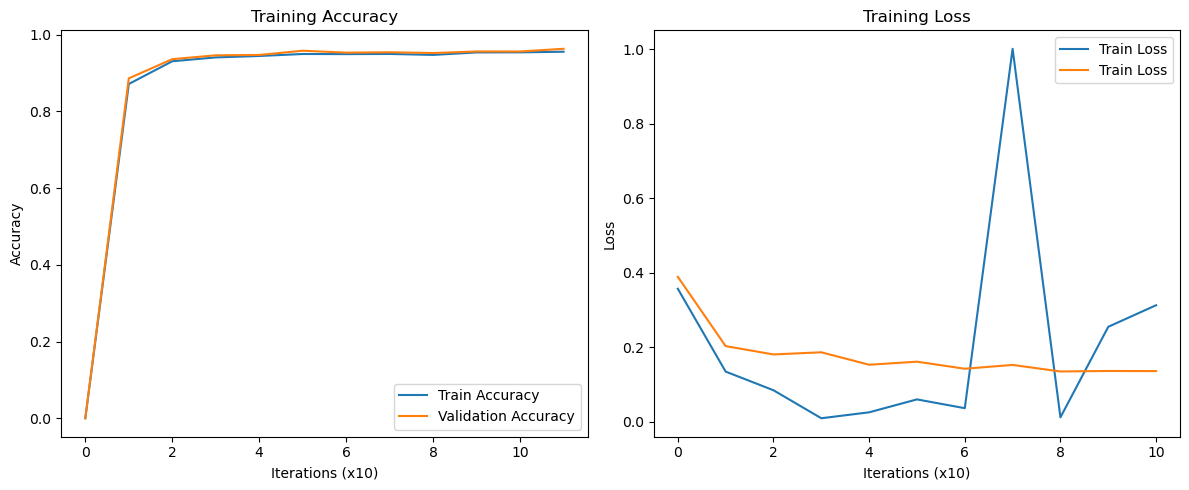

Iteration 110 out of 2000
Iteration 120 out of 2000
Iteration 130 out of 2000
Iteration 140 out of 2000
Iteration 150 out of 2000
Iteration 160 out of 2000
Iteration 170 out of 2000
Iteration 180 out of 2000
Iteration 190 out of 2000
Iteration 200 out of 2000
Train Accuracy: 0.956
Validation Accuracy: 0.965
Train Loss: 0.172
Validation Loss: 0.133


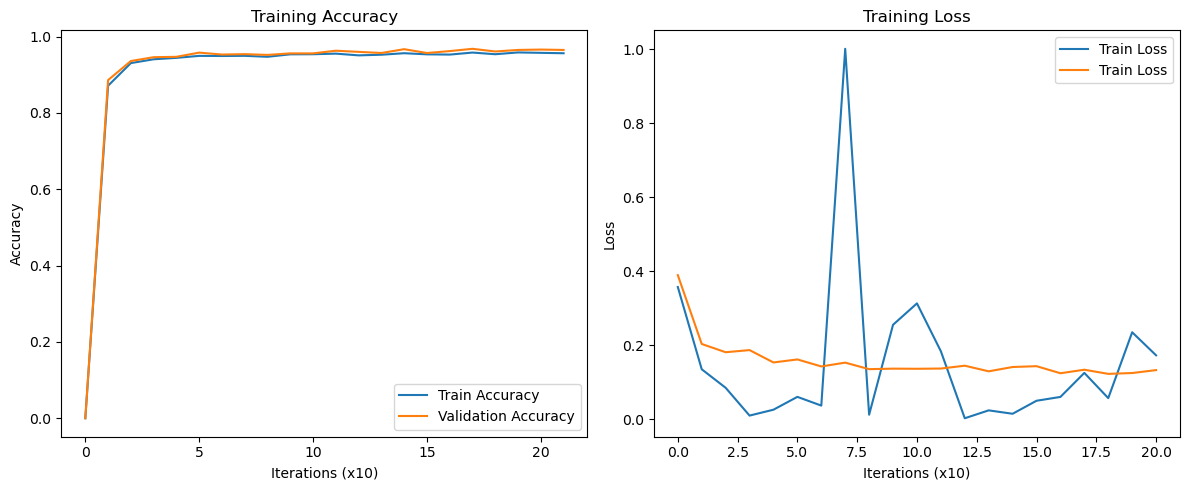

Iteration 210 out of 2000
Iteration 220 out of 2000
Iteration 230 out of 2000
Iteration 240 out of 2000
Iteration 250 out of 2000
Iteration 260 out of 2000
Iteration 270 out of 2000
Iteration 280 out of 2000
Iteration 290 out of 2000
Iteration 300 out of 2000
Train Accuracy: 0.956
Validation Accuracy: 0.964
Train Loss: 0.182
Validation Loss: 0.135


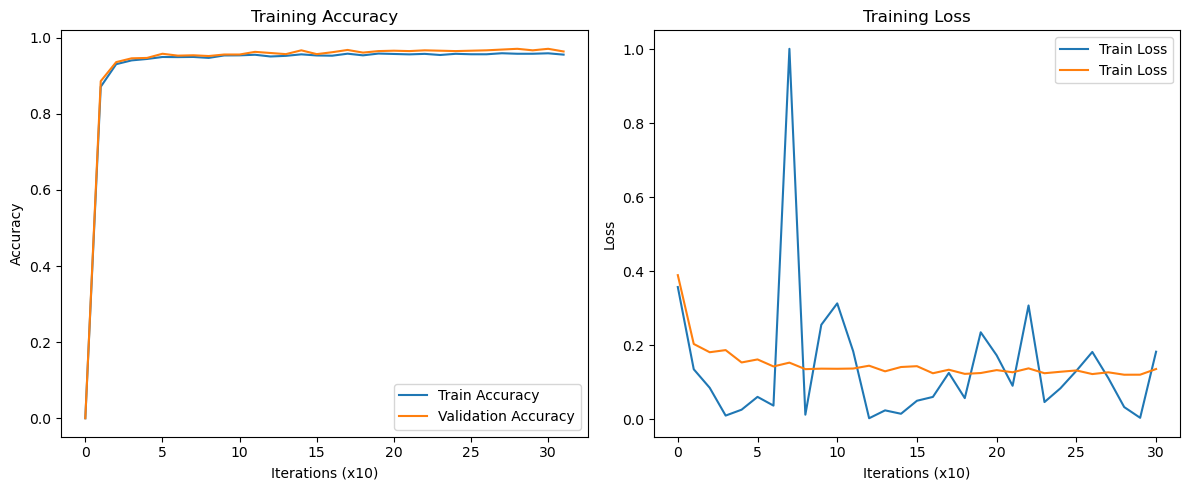

Iteration 310 out of 2000
Iteration 320 out of 2000
Iteration 330 out of 2000
Iteration 340 out of 2000
Iteration 350 out of 2000
Iteration 360 out of 2000
Iteration 370 out of 2000
Iteration 380 out of 2000
Iteration 390 out of 2000
Iteration 400 out of 2000
Train Accuracy: 0.959
Validation Accuracy: 0.966
Train Loss: 0.028
Validation Loss: 0.129


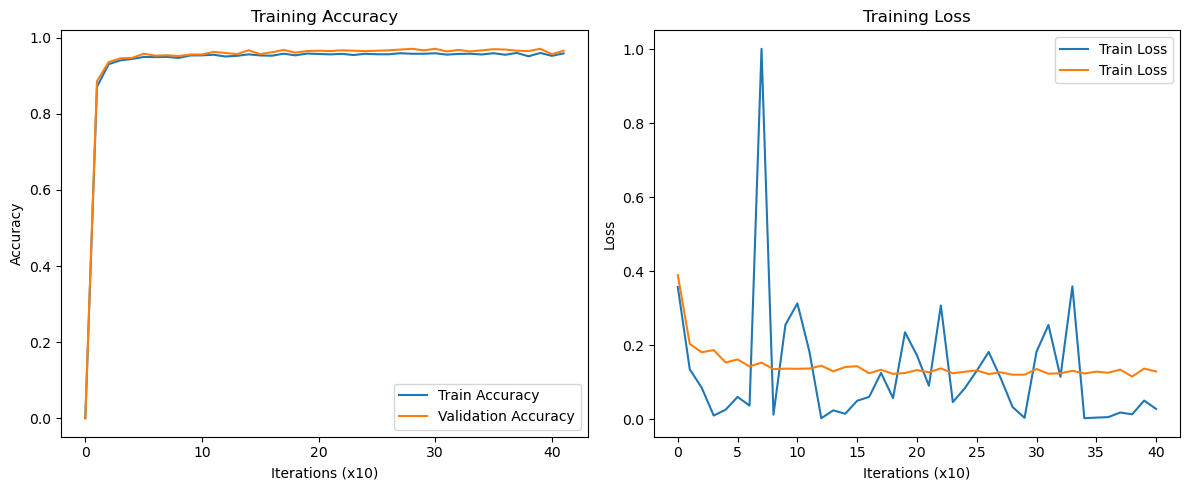

Iteration 410 out of 2000
Iteration 420 out of 2000
Iteration 430 out of 2000
Iteration 440 out of 2000
Iteration 450 out of 2000
Iteration 460 out of 2000
Iteration 470 out of 2000
Iteration 480 out of 2000
Iteration 490 out of 2000
Iteration 500 out of 2000
Train Accuracy: 0.956
Validation Accuracy: 0.970
Train Loss: 0.041
Validation Loss: 0.121


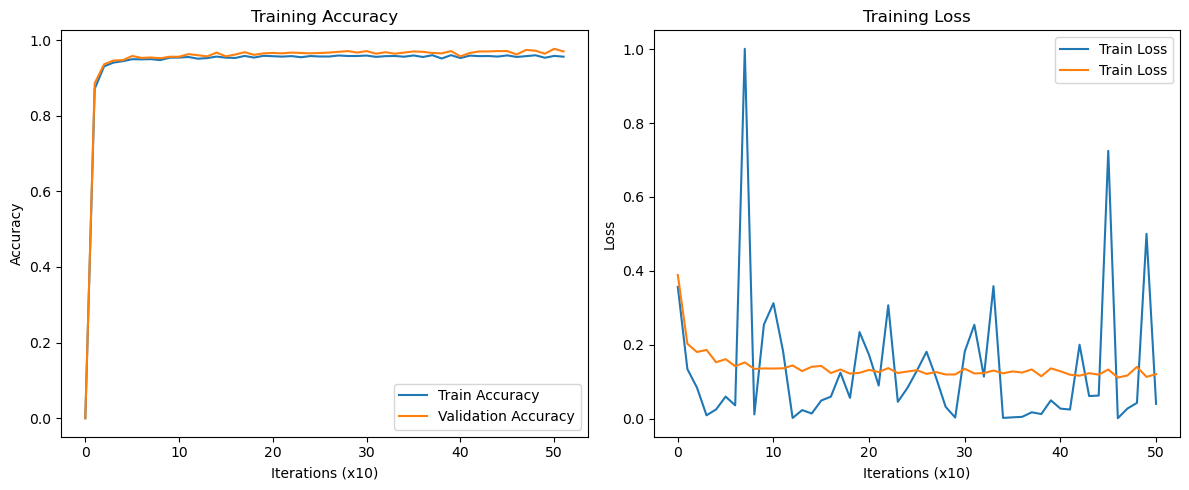

Iteration 510 out of 2000
Iteration 520 out of 2000
Iteration 530 out of 2000
Iteration 540 out of 2000
Iteration 550 out of 2000
Iteration 560 out of 2000
Iteration 570 out of 2000
Iteration 580 out of 2000
Iteration 590 out of 2000
Iteration 600 out of 2000
Train Accuracy: 0.961
Validation Accuracy: 0.972
Train Loss: 0.002
Validation Loss: 0.114


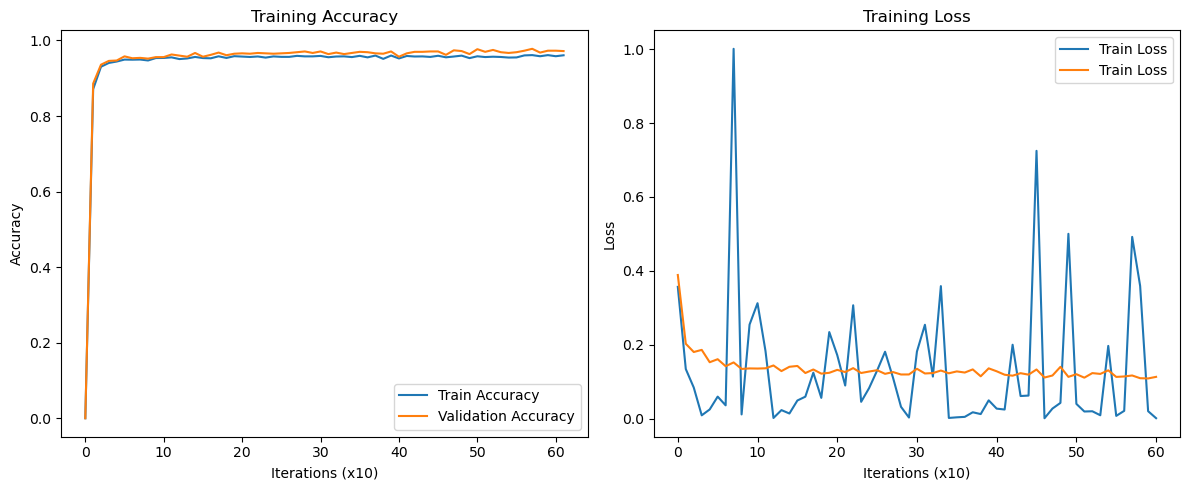

Iteration 610 out of 2000
Iteration 620 out of 2000
Iteration 630 out of 2000
Iteration 640 out of 2000
Iteration 650 out of 2000
Iteration 660 out of 2000
Iteration 670 out of 2000
Iteration 680 out of 2000
Iteration 690 out of 2000
Iteration 700 out of 2000
Train Accuracy: 0.962
Validation Accuracy: 0.972
Train Loss: 0.125
Validation Loss: 0.109


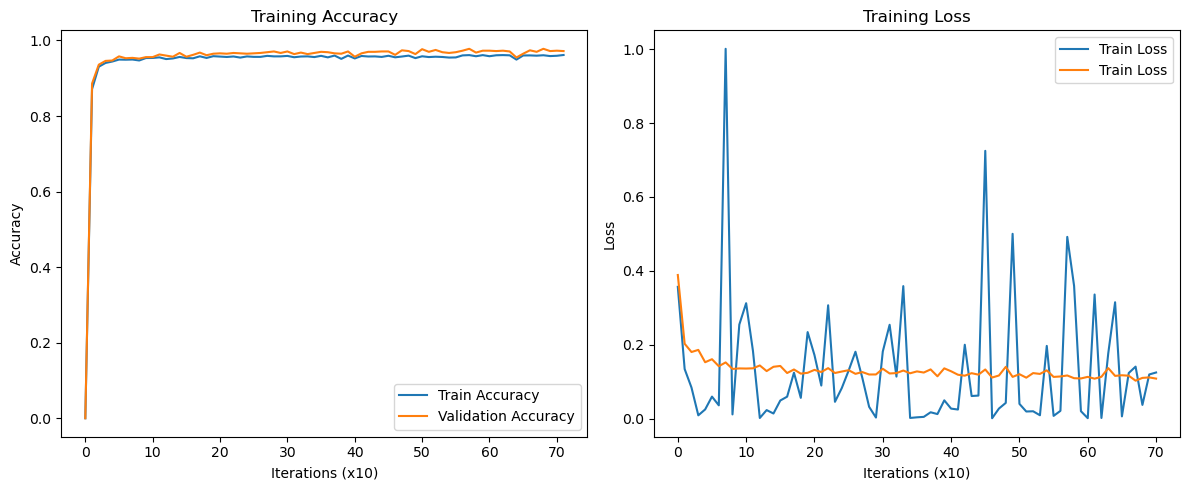

Iteration 710 out of 2000
Iteration 720 out of 2000
Iteration 730 out of 2000
Iteration 740 out of 2000
Iteration 750 out of 2000
Iteration 760 out of 2000
Iteration 770 out of 2000
Iteration 780 out of 2000
Iteration 790 out of 2000
Iteration 800 out of 2000
Train Accuracy: 0.961
Validation Accuracy: 0.972
Train Loss: 0.005
Validation Loss: 0.120


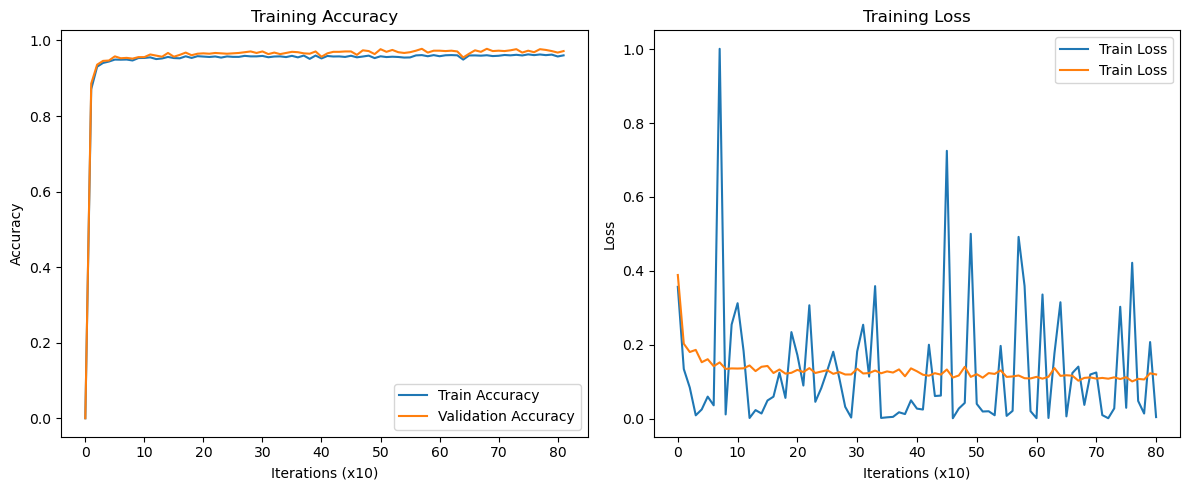

Iteration 810 out of 2000
Iteration 820 out of 2000
Iteration 830 out of 2000
Iteration 840 out of 2000
Iteration 850 out of 2000
Iteration 860 out of 2000
Iteration 870 out of 2000
Iteration 880 out of 2000
Iteration 890 out of 2000
Iteration 900 out of 2000
Train Accuracy: 0.964
Validation Accuracy: 0.976
Train Loss: 0.054
Validation Loss: 0.108


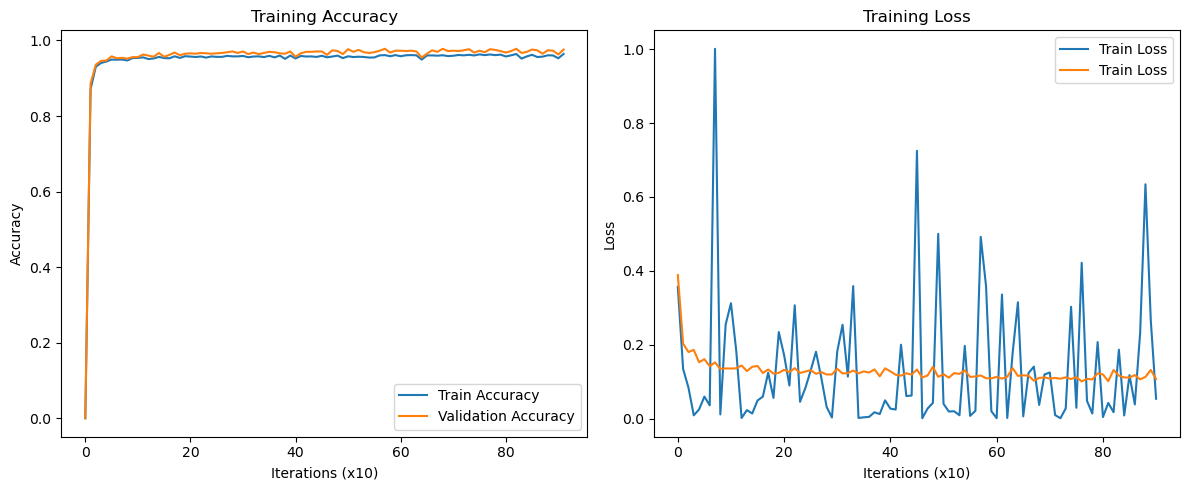

Iteration 910 out of 2000
Iteration 920 out of 2000
Iteration 930 out of 2000
Iteration 940 out of 2000
Iteration 950 out of 2000
Iteration 960 out of 2000
Iteration 970 out of 2000
Iteration 980 out of 2000
Iteration 990 out of 2000
Iteration 1000 out of 2000
Train Accuracy: 0.964
Validation Accuracy: 0.972
Train Loss: 0.021
Validation Loss: 0.105


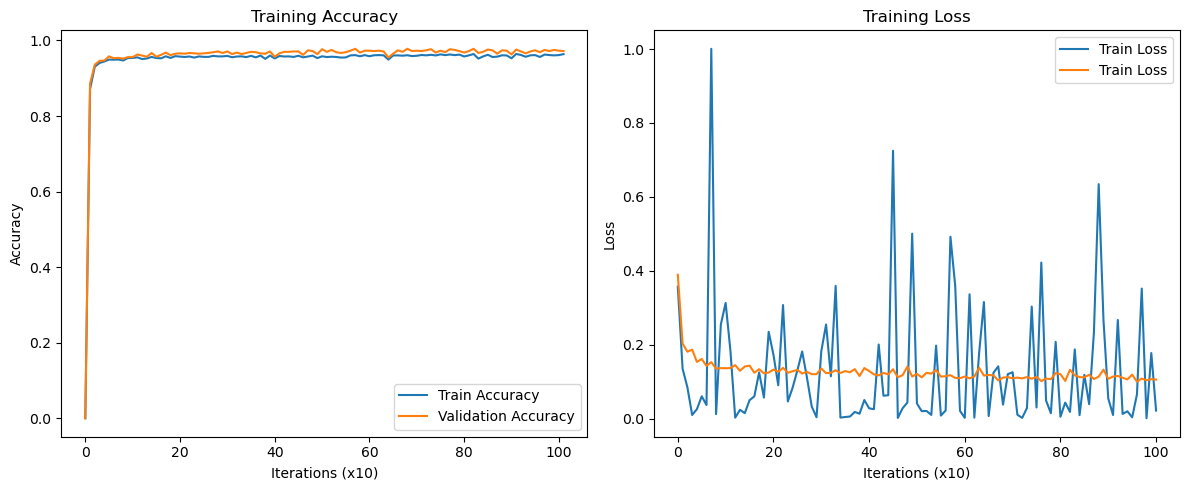

Iteration 1010 out of 2000
Iteration 1020 out of 2000
Iteration 1030 out of 2000
Iteration 1040 out of 2000
Iteration 1050 out of 2000
Iteration 1060 out of 2000
Iteration 1070 out of 2000
Iteration 1080 out of 2000
Iteration 1090 out of 2000
Iteration 1100 out of 2000
Train Accuracy: 0.964
Validation Accuracy: 0.975
Train Loss: 0.113
Validation Loss: 0.099


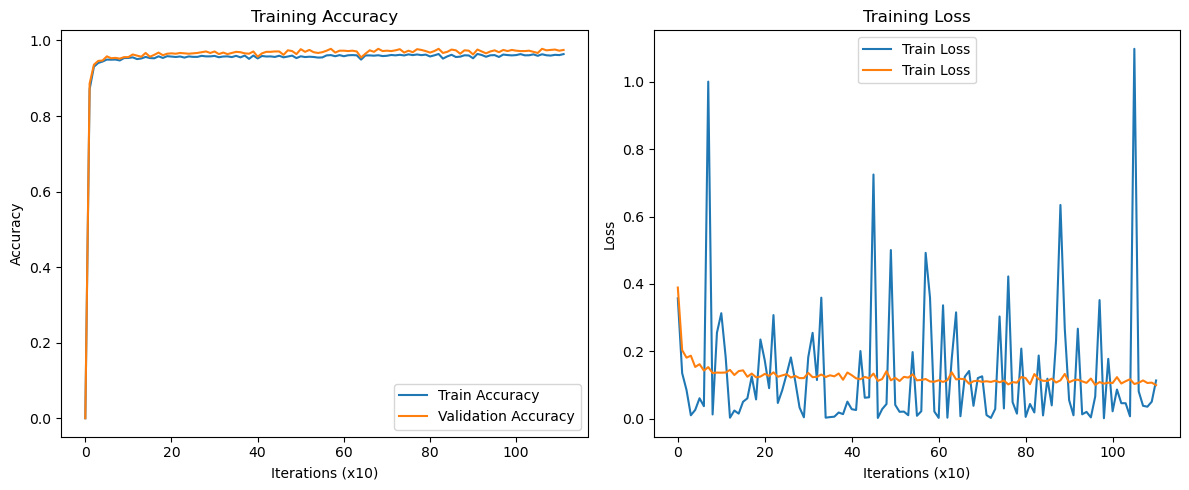

Iteration 1110 out of 2000
Iteration 1120 out of 2000
Iteration 1130 out of 2000
Iteration 1140 out of 2000
Iteration 1150 out of 2000
Iteration 1160 out of 2000
Iteration 1170 out of 2000
Iteration 1180 out of 2000
Iteration 1190 out of 2000
Iteration 1200 out of 2000
Train Accuracy: 0.955
Validation Accuracy: 0.965
Train Loss: 0.074
Validation Loss: 0.121


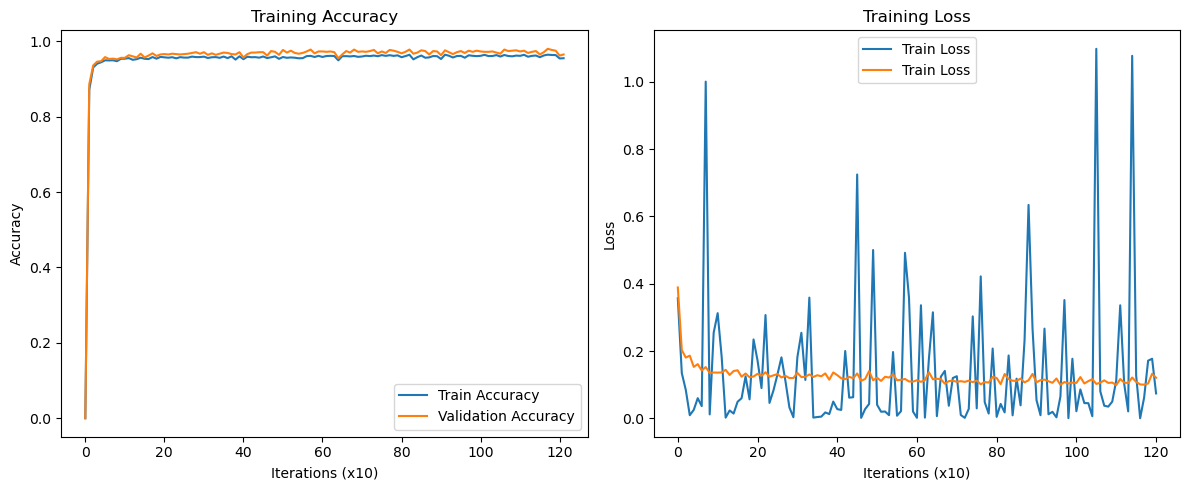

Iteration 1210 out of 2000
Iteration 1220 out of 2000
Iteration 1230 out of 2000
Iteration 1240 out of 2000
Iteration 1250 out of 2000
Iteration 1260 out of 2000
Iteration 1270 out of 2000
Iteration 1280 out of 2000
Iteration 1290 out of 2000
Iteration 1300 out of 2000
Train Accuracy: 0.960
Validation Accuracy: 0.969
Train Loss: 0.012
Validation Loss: 0.111


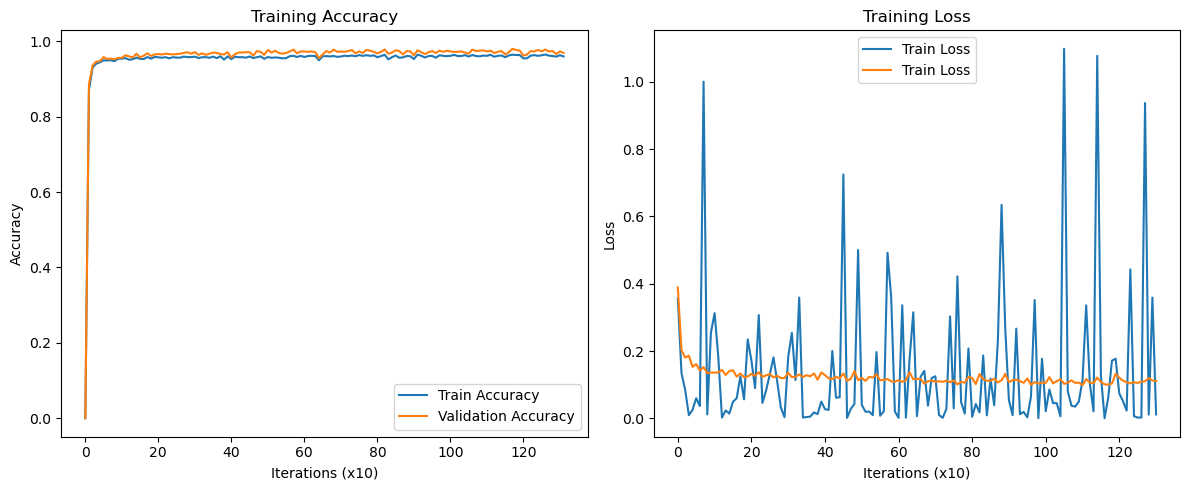

Iteration 1310 out of 2000
Iteration 1320 out of 2000
Iteration 1330 out of 2000
Iteration 1340 out of 2000
Iteration 1350 out of 2000
Iteration 1360 out of 2000
Iteration 1370 out of 2000
Iteration 1380 out of 2000
Iteration 1390 out of 2000
Iteration 1400 out of 2000
Train Accuracy: 0.963
Validation Accuracy: 0.969
Train Loss: 1.102
Validation Loss: 0.107


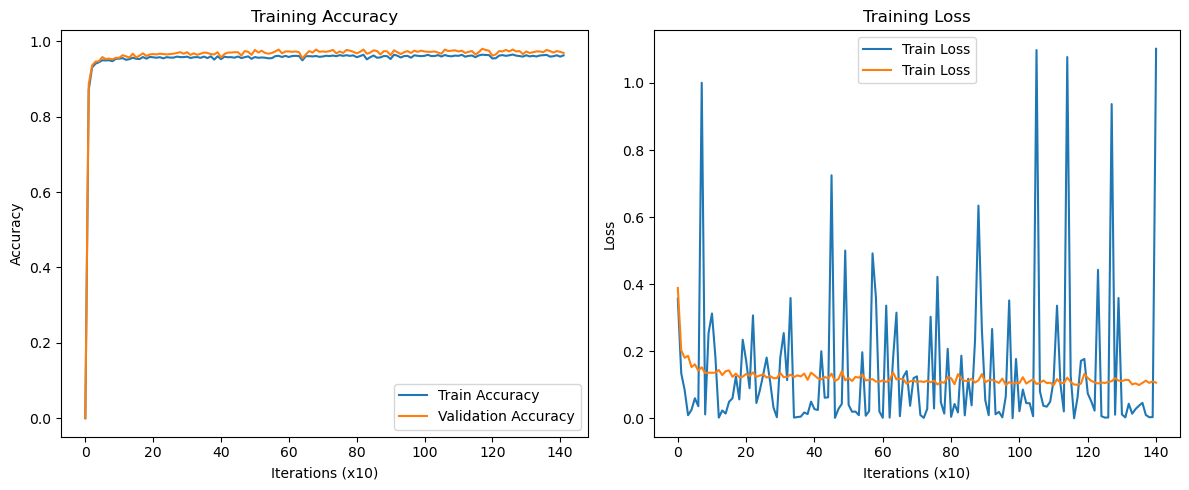

Iteration 1410 out of 2000
Iteration 1420 out of 2000
Iteration 1430 out of 2000
Iteration 1440 out of 2000
Iteration 1450 out of 2000
Iteration 1460 out of 2000
Iteration 1470 out of 2000
Iteration 1480 out of 2000
Iteration 1490 out of 2000
Iteration 1500 out of 2000
Train Accuracy: 0.962
Validation Accuracy: 0.976
Train Loss: 0.009
Validation Loss: 0.099


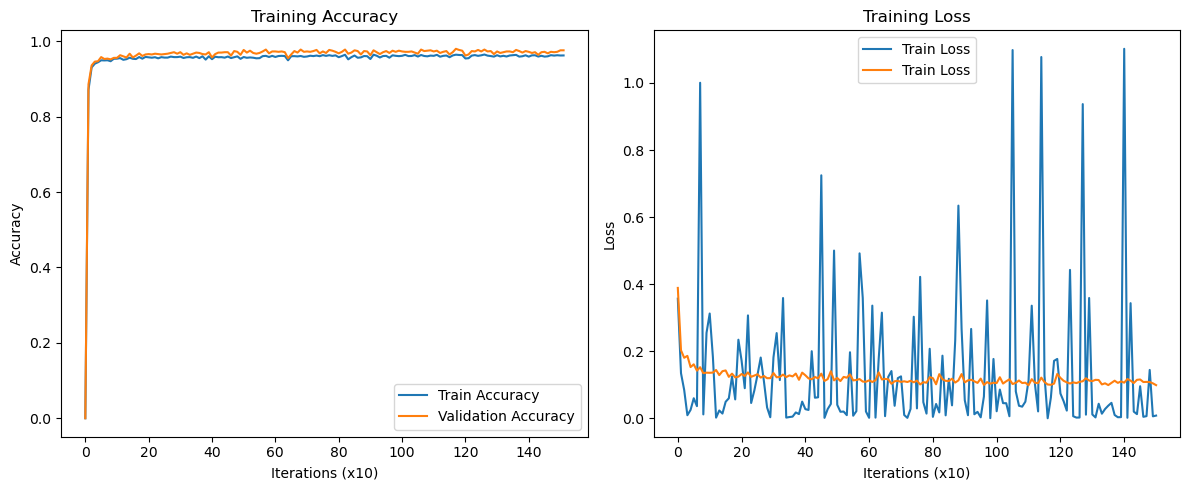

Iteration 1510 out of 2000
Iteration 1520 out of 2000
Iteration 1530 out of 2000
Iteration 1540 out of 2000
Iteration 1550 out of 2000
Iteration 1560 out of 2000
Iteration 1570 out of 2000
Iteration 1580 out of 2000
Iteration 1590 out of 2000
Iteration 1600 out of 2000
Train Accuracy: 0.961
Validation Accuracy: 0.964
Train Loss: 0.025
Validation Loss: 0.116


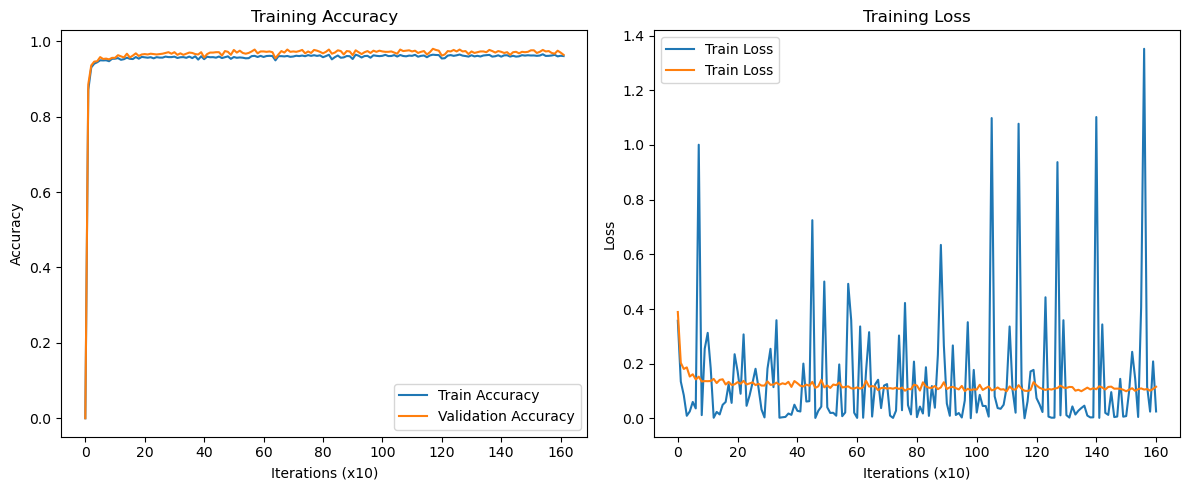

Iteration 1610 out of 2000
Iteration 1620 out of 2000
Iteration 1630 out of 2000
Iteration 1640 out of 2000
Iteration 1650 out of 2000
Iteration 1660 out of 2000
Iteration 1670 out of 2000
Iteration 1680 out of 2000
Iteration 1690 out of 2000
Iteration 1700 out of 2000
Train Accuracy: 0.963
Validation Accuracy: 0.974
Train Loss: 0.482
Validation Loss: 0.107


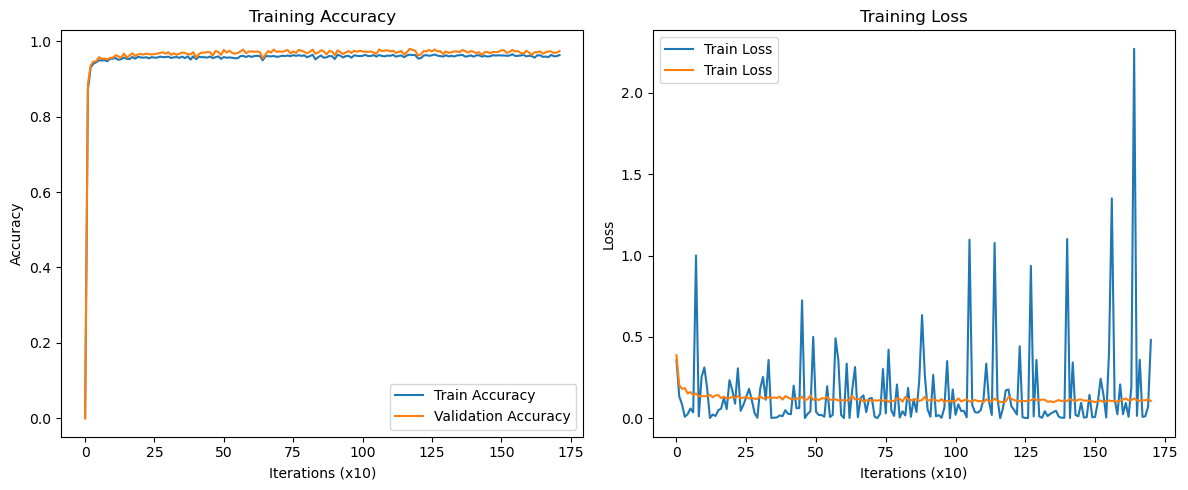

Iteration 1710 out of 2000
Iteration 1720 out of 2000
Iteration 1730 out of 2000
Iteration 1740 out of 2000
Iteration 1750 out of 2000
Iteration 1760 out of 2000
Iteration 1770 out of 2000
Iteration 1780 out of 2000
Iteration 1790 out of 2000
Iteration 1800 out of 2000
Train Accuracy: 0.964
Validation Accuracy: 0.975
Train Loss: 0.001
Validation Loss: 0.099


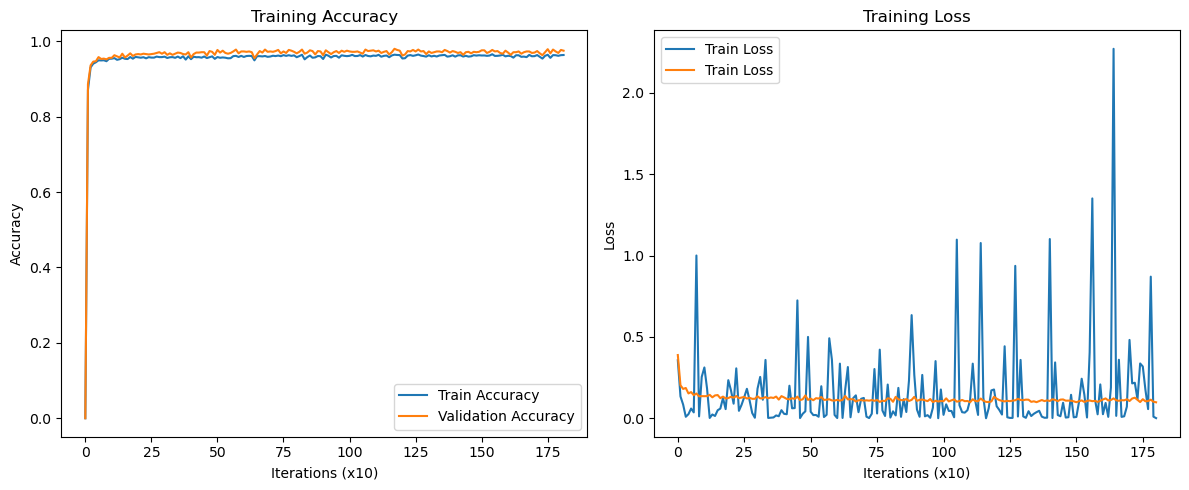

Iteration 1810 out of 2000
Iteration 1820 out of 2000
Iteration 1830 out of 2000
Iteration 1840 out of 2000
Iteration 1850 out of 2000
Iteration 1860 out of 2000
Iteration 1870 out of 2000
Iteration 1880 out of 2000
Iteration 1890 out of 2000
Iteration 1900 out of 2000
Train Accuracy: 0.960
Validation Accuracy: 0.968
Train Loss: 0.241
Validation Loss: 0.117


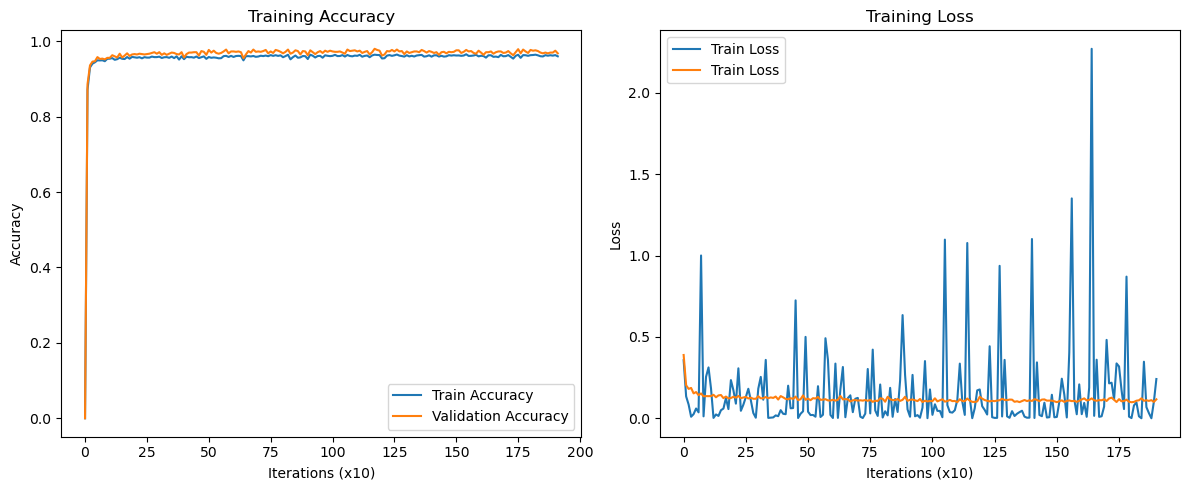

Iteration 1910 out of 2000
Iteration 1920 out of 2000
Iteration 1930 out of 2000
Iteration 1940 out of 2000
Iteration 1950 out of 2000
Iteration 1960 out of 2000
Iteration 1970 out of 2000
Iteration 1980 out of 2000
Iteration 1990 out of 2000
Training completed in 5682.89 seconds.


In [9]:
W1, b1, W2, b2 = mini_batch_gradient_descent(values_train, labels_train, EPOCHS, ALPHA, BATCHSIZE, values_validation, labels_validation)

In [10]:
def evaluate_model(W1, b1, W2, b2, values, labels):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, values)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, labels)
    loss = cross_entropy_loss(A2, one_hot(labels))

    return accuracy, loss

accuracy_test, loss_test = evaluate_model(W1, b1, W2, b2, values_test, labels_test)
print(f"Test Accuracy: {accuracy_test:.3f}")
print(f"Test Loss: {loss_test:.3f}")

Test Accuracy: 0.931
Test Loss: 0.290
